Create database

In [230]:
import pandas as pd
import matplotlib.pyplot as plt

import engarde.decorators as ed

pd.set_option('display.max_colwidth', None)


def read(file):
    df = ((pd.read_excel(file, skiprows=2, usecols=columns))
          .rename(columns, axis=1)
          .pipe(str_to_numeric, ['fat', 'carbs', 'fiber', 'protein'])
          .pipe(str_to_lower, ['name', 'category'])
          .pipe(strip_strings, ['name'])
          .assign(net_carbs = lambda df: df.carbs - df.fiber)
          .dropna(how='any'))
    return df


columns = {
    'Name': 'name',
    'Kategorie': 'category',
    'Bezugseinheit': 'units',
    'Energie, Kalorien': 'calories',
    'Fett, total (g)': 'fat',
    'Kohlenhydrate, verfügbar (g)': 'carbs',
    'Nahrungsfasern (g)': 'fiber',
    'Protein (g)': 'protein'
}


def strip_strings(df, columns):
    """
    Remove leading and trailing whitespace from strings.
    """
    df = df.copy()
    def strip(col):
        return col.str.strip()
    
    df[columns] = df[columns].apply(strip)
    return df
    
    
def str_to_numeric(df, columns):
    """
    Convert string columns to numeric.
    """
    df = df.copy()
    def converter(col):
        return pd.to_numeric(col, errors='coerce')

    df[columns] = df[columns].apply(converter)
    return df


def str_to_lower(df, columns):
    """
    Convert string columns to lower-case.
    """
    df = df.copy()
    def converter(col):
        return col.str.lower()
    
    df[columns] = df[columns].apply(converter)
    return df


data = 'Schweizer-Nährwertdatenbank-V6.1.xlsx'

foods = read(data)
foods.head()

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
0,agar agar,verschiedenes/gelier- und bindemittel,pro 100g essbarer Anteil,160,0.2,0.0,74.1,2.4,-74.1
1,agavensirup,süssigkeiten/zucker und süssstoffe,pro 100g essbarer Anteil,293,0.0,73.1,0.0,0.2,73.1
2,"älplermagronen, zubereitet",gerichte/sonstige salzige/rezente gerichte,pro 100g essbarer Anteil,183,9.0,18.6,1.7,6.0,16.9
3,"amaranth, samen, gekocht (ohne zugabe von fett und salz)","getreideprodukte, hülsenfrüchte und kartoffeln/sonstige getreideprodukte",pro 100g essbarer Anteil,126,2.4,19.1,3.7,5.3,15.4
4,"amaranth, samen, roh","getreideprodukte, hülsenfrüchte und kartoffeln/sonstige getreideprodukte",pro 100g essbarer Anteil,376,7.0,56.8,11.0,15.8,45.8


Find items

In [288]:
def find_item(item):
    return foods[foods.name.str.contains(item)]

find_item('kak')

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
345,kakaobutter,fette und öle/fette,pro 100g essbarer Anteil,900,100.0,0.0,0.0,0.0,0.0
346,kakaopulver,süssigkeiten/schokolade und kakaoerzeugnisse;alkoholfreie getränke/kakaogetränke,pro 100g essbarer Anteil,419,24.5,10.8,32.7,22.5,-21.9
347,"kaki, roh",früchte/früchte frisch,pro 100g essbarer Anteil,71,0.2,15.3,2.5,0.7,12.8


Build dataset with my foods 

In [310]:
my_foods = {
    'avocado, roh': 'avocado',
    'blattsalat (durchschnitt), roh': 'avg lettuce',
    'champignon, roh': 'mushrooms',    
    'fleisch (durchschnitt exkl. innereien), roh': 'avg meat',
    'gemüse (durchschnitt), roh': 'avg veg',
    'hühnerei, ganz, festgekocht': 'egg',
    'kakaopulver': 'cocoa powder', 
    'kochbutter': 'butter',
    'kokosfett': 'coconut fat',
    'kokosnuss, getrocknet (kokosrapseln, kokosflocken)': 'coconut flakes',
    'mandel': 'almond',
    'olivenöl': 'olive oil',
    'peperoni, rot, roh': 'red pepper',
    'poulet, schenkel, mit haut, gebraten (ohne zusatz von fett und salz)': 'chicken leg',
    'poulet, brust, schnitzel oder geschnetzeltes, gebraten (ohne zusatz von fett und salz)': 'chicken breast',
    'samen, kerne, nüsse (durchschnitt), ungesalzen': 'nuts and seed mix',
    'schwein, hals, steak, gebraten (ohne zusatz von fett und salz)': 'pork steak',
    'spinat, roh': 'spinach', 
    'tofu': 'tofu',
}


def make_myfoods(data, foods):
    df = data.copy()
    df = df.loc[data.name.isin(foods)]
    df['name'] = df['name'].map(foods)
    return df


myfoods = make_myfoods(foods, my_foods)
myfoods.head()

,name,category,units,calories,fat,carbs,fiber,protein,net_carbs
33,avocado,"gemüse/gemüse frisch;nüsse, samen und ölfrüchte",pro 100g essbarer Anteil,144,14.2,0.8,3.0,1.8,-2.2
80,avg lettuce,gemüse/gemüse frisch,pro 100g essbarer Anteil,18,0.3,1.4,1.9,1.6,-0.5
139,mushrooms,gemüse/pilze,pro 100g essbarer Anteil,25,0.3,1.1,1.9,3.7,-0.8
222,avg meat,"fleisch und innereien/kalb;fleisch und innereien/geflügel;fleisch und innereien/lamm, schaf;fleisch und innereien/rind;fleisch und innereien/schwein;fleisch und innereien/wild",pro 100g essbarer Anteil,145,6.6,0.0,0.0,21.4,0.0
255,avg veg,gemüse/gemüse frisch,pro 100g essbarer Anteil,26,0.3,3.7,2.0,1.3,1.7


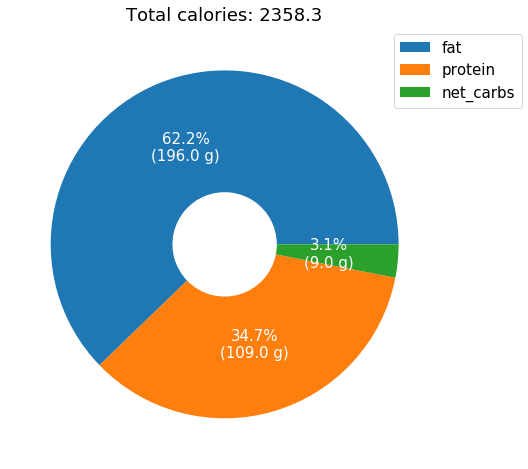

In [291]:
lunch = {
    'avg lettuce': 1.5,
    'avocado': 1.5,
    'olive oil': 0.2,
    'red pepper': 1,
    'tofu': 1.5, 
    'nuts and seed mix': 0.5
}

creatine_bomb = {
    'cocoa powder': 0.1,
    'coconut fat': 0.5,
    'coconut flakes': 0.1,
    'almond': 0.2,
}

snack = {
    'egg': 1.3,
    'olive oil': 0.2,
    'spinach': 0.4,
    'mushrooms': 0.5,
}

supper = {
    'avg veg': 3,
    'avocado': 1.5,
    'butter': 0.2,
    'pork steak': 2
}


def calc_nutrients(foods, portions):
    """
    Calculate nutrients for portions.
    """
    pieces = []
    nutrients = ['calories', 'fat', 'protein', 'net_carbs']
    for ingredient, portion in portions.items():
        nuts = foods.loc[foods.name == ingredient, nutrients] * portion
        pieces.append(nuts)
        
    nutrients = pd.concat(pieces)
    nutrients[nutrients < 0] = 0
    return nutrients.sum()


def make_doughnut(data):
    """
    Create a piechart based on nutrition data.
    """
    calories = data[0]
    macros = data[1:]

    def func(pct, allvals):
        absolute = int(pct / 100 * sum(allvals))
        return f"{pct:.1f}%\n({absolute:.1f} g)"

    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, _, _ = ax.pie(macros, wedgeprops=dict(width=0.7),
                          textprops=dict(color='white', size=15),
                          autopct=lambda pct: func(pct, macros))
    ax.legend(wedges, macros.index,
              bbox_to_anchor=(.7, 0, .5, 1),
              fontsize=15)
    ax.set_title(f'Total calories: {calories}',
                 fontdict=dict(size=18));
    

meals = {**lunch, **snack, **supper}

nuts = calc_nutrients(myfoods, meals)

make_doughnut(nuts)